# VDP方程式(ランダムなシフト付きsin外力のある状態)

VDP方程式の外力のある場合に関して，$\sin$ 波に位相のランダムなシフトがある場合を考える．

In [3]:
#必要なパッケージのインポート

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import reservoirpy as rpy

from scipy.integrate import solve_ivp
import pandas as pd
from reservoirpy.observables import nrmse, rsquare

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import os

rpy.verbosity(0)

from reservoirpy.nodes import Reservoir, Ridge
from reservoirpy.datasets import mackey_glass

# just a little tweak to center the plots, nothing to worry about
from IPython.core.display import HTML
HTML("""
<style>
.img-center {
    display: block;
    margin-left: auto;
    margin-right: auto;
    }
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    }
</style>
""")

rpy.set_seed(42)

import pandas as pd

%time


CPU times: user 6 µs, sys: 5 µs, total: 11 µs
Wall time: 21.2 µs


生成データの描画．　

In [4]:
shift_hour = 12
opt_shift_hour = 0

# generative model の結果を取得
# CSVファイルを読み込む際にヘッダーがないことを指定
filename_with_force_result = f"opt_{opt_shift_hour}_VDP_gen/VDP_{shift_hour}.csv"
data_loaded_with_force_result = pd.read_csv(filename_with_force_result, header=None)

# 0, 1, 2列目を抽出してNumpy配列に格納
X_result = data_loaded_with_force_result.iloc[:, [0, 1, 2]].values

# 実データを取得
filename_with_force_val = f"opt_{opt_shift_hour}_VDP_val/VDP_{shift_hour}.csv"
data_loaded_with_force_val = pd.read_csv(filename_with_force_val, header=None)

# 0, 1, 2列目を抽出してNumpy配列に格納
X_val = data_loaded_with_force_val.iloc[:, [0, 1, 2]].values


In [5]:
def plot_generation(X_gen, X_t, nb_generations, warming_out=None, warming_inputs=None, seed_timesteps=0):
    plt.figure(figsize=(15, 5))
    if warming_out is not None:
        plt.plot(np.vstack([warming_out, X_gen]), label="Generated timeseries")
    else:
        plt.plot(X_gen, label="Generated timeseries")

    plt.plot(np.arange(nb_generations) + seed_timesteps, X_t, linestyle="--", label="Real timeseries")

    # `warming_inputs`のサイズを検証して調整します。
    if warming_inputs is not None and len(warming_inputs) > seed_timesteps:
        # `seed_timesteps`に合わせてサイズを調整
        warming_inputs = warming_inputs[:seed_timesteps]
        plt.plot(warming_inputs, linestyle="--", label="Warmup")

    plt.plot(np.arange(nb_generations) + seed_timesteps, np.abs(X_t - X_gen), label="Absolute deviation")

    if seed_timesteps > 0:
        plt.fill_between([0, seed_timesteps], *plt.ylim(), facecolor='lightgray', alpha=0.5, label="Warmup period")

    plt.legend()
    plt.show()


In [6]:
train_len = 40000
start_time = 0
test_length = 20000
nb_generations = 10000

seed_timesteps = test_length 


In [7]:
X_val_amp = X_val[:nb_generations]
X_result_amp = X_result[:nb_generations]

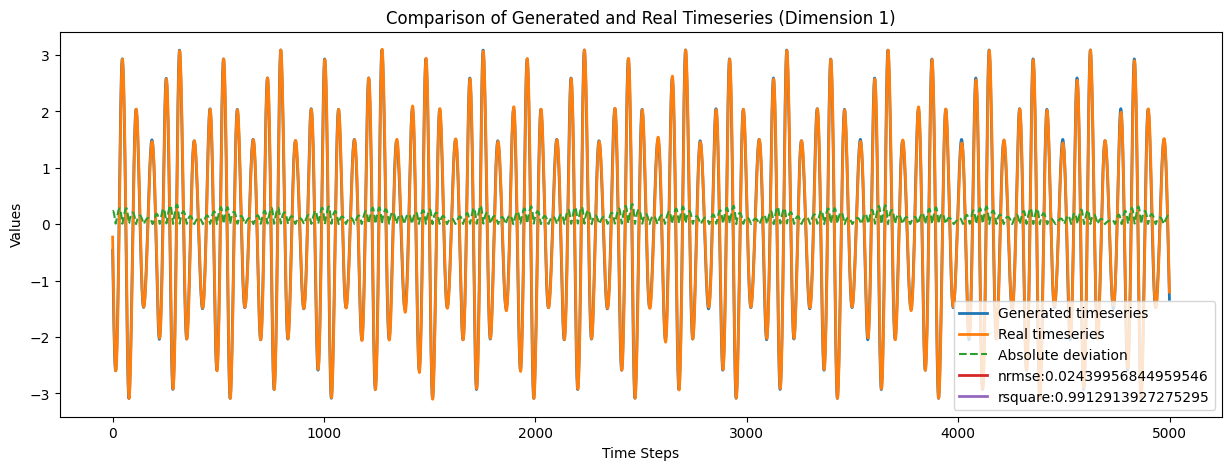

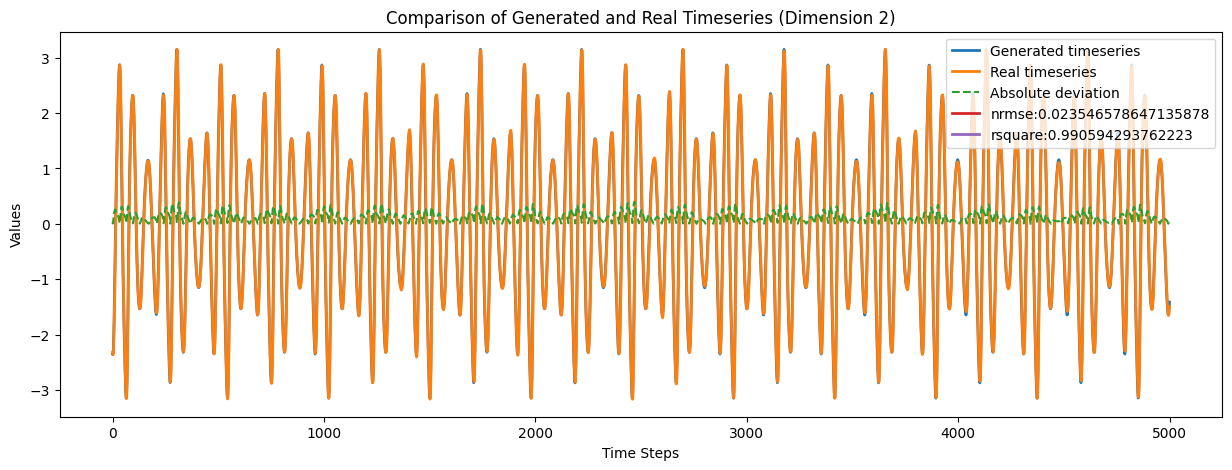

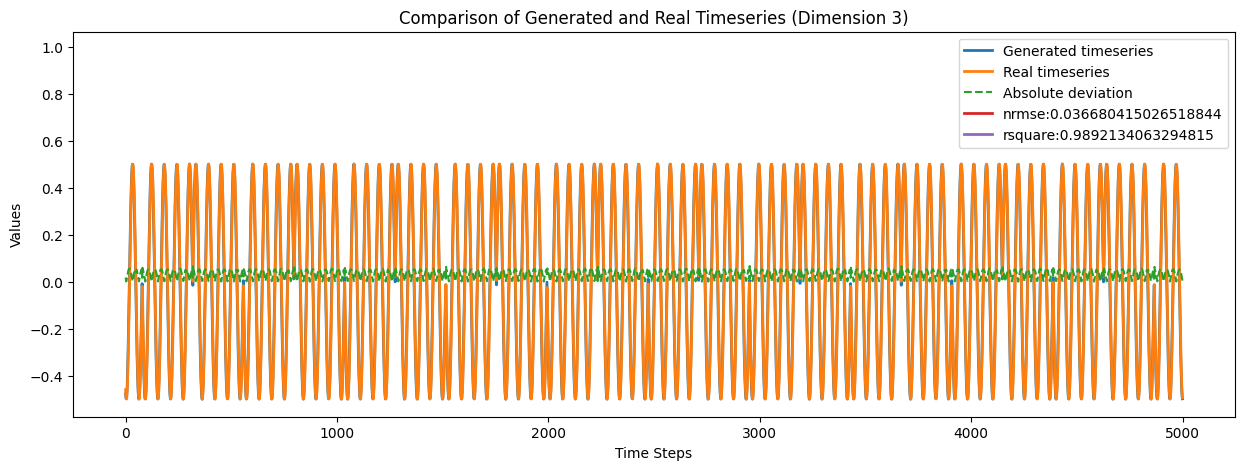

In [8]:
sample = 5000

# 時系列データの比較を行う関数
def compare_timeseries_multidimensional(X_gen, X_t):
    num_dimensions = X_gen.shape[1]  # 次元数を取得
    for dim in range(num_dimensions):
        plt.figure(figsize=(15, 5))
        plt.plot(X_gen[:, dim][:5000], label="Generated timeseries", linewidth=2)
        plt.plot(X_t[:, dim][:5000], label="Real timeseries", linewidth=2)
        plt.plot(np.abs(X_t[:, dim][:5000] - X_gen[:, dim][:5000]), label="Absolute deviation", linestyle='--')
        plt.plot(nrmse(X_gen[:, dim][:5000], X_t[:, dim][:5000]), label=f"nrmse:{nrmse(X_gen[:, dim][:5000], X_t[:, dim][:5000])}", linewidth=2)
        plt.plot(rsquare(X_gen[:, dim][:5000], X_t[:, dim][:5000]), label=f"rsquare:{rsquare(X_gen[:, dim][:5000], X_t[:, dim][:5000])}", linewidth=2)

        plt.title(f'Comparison of Generated and Real Timeseries (Dimension {dim+1})')
        plt.xlabel('Time Steps')
        plt.ylabel('Values')
        plt.legend()        
        plt.show()
        
# 使用例:
compare_timeseries_multidimensional(X_result_amp, X_val_amp)


In [9]:
dir_name_plot = f'opt_{opt_shift_hour}_plots'
os.makedirs(dir_name_plot, exist_ok=True)


In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

plt.ioff()

for shift_hour in range(-12, 13):
    filename_with_force_result = f"opt_{opt_shift_hour}_VDP_gen/VDP_{shift_hour}.csv"
    data_loaded_with_force_result = pd.read_csv(filename_with_force_result, header=None)
    X_result = data_loaded_with_force_result.iloc[:, [0, 1, 2]].values

    filename_with_force_val = f"opt_{opt_shift_hour}_VDP_val/VDP_{shift_hour}.csv"
    data_loaded_with_force_val = pd.read_csv(filename_with_force_val, header=None)
    X_val = data_loaded_with_force_val.iloc[:, [0, 1, 2]].values
    
    X_val_amp = X_val[:nb_generations]
    X_result_amp = X_result[:nb_generations]
    
    X_gen, X_t = X_result_amp, X_val_amp

    num_dimensions = X_gen.shape[1]

    # サブプロットの作成
    fig, axs = plt.subplots(num_dimensions, 1, figsize=(15, 5 * num_dimensions))

    for dim in range(num_dimensions):
        axs[dim].plot(X_gen[:, dim][:5000], label="Generated timeseries", linewidth=2)
        axs[dim].plot(X_t[:, dim][:5000], label="Real timeseries", linewidth=2)
        axs[dim].plot(np.abs(X_t[:, dim][:5000] - X_gen[:, dim][:5000]), label="Absolute deviation", linestyle='--')
        axs[dim].plot(nrmse(X_gen[:, dim][:5000], X_t[:, dim][:5000]), label=f"nrmse:{nrmse(X_gen[:, dim][:5000], X_t[:, dim][:5000])}", linewidth=2)
        axs[dim].plot(rsquare(X_gen[:, dim][:5000], X_t[:, dim][:5000]), label=f"rsquare:{rsquare(X_gen[:, dim][:5000], X_t[:, dim][:5000])}", linewidth=2)
        axs[dim].set_title(f'Dimension {dim+1} Comparison')
        axs[dim].set_xlabel('Time Steps')
        axs[dim].set_ylabel('Values')
        axs[dim].legend()

    plt.tight_layout()

    # グラフをファイルに保存
    plot_filename = f"{dir_name_plot}/plot_{shift_hour}.png"
    plt.savefig(plot_filename)
    plt.close()
